Note to self 6/4-22:
Totalt antall stemmer godt med PSAK120.
Alt med DP stemmer bra med excel, men ikke så bra med PSAK120.
Automatisk stemmer så bra at autograd blir det samme på figur 1, men litt unøyaktighet her også.


For the future 22/4-22:
Når vi joiner med `PEN.T_SKJEMA` forsvinner (nesten) alle ikke-selvbetjente saker. Teste ut andre typer join for å konservere antall saker. Hvordan håndtere resulterende nullverdier fra `PEN.T_SKJEMA`?
Kan være nødvendig å se mer på `OPPRETTET_AV`; mye der som kommer fra batch.

In [258]:
import cx_Oracle
import pandas as pd
import numpy as np
import sys
import os
import importlib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.cloud import secretmanager

sys.path.append('../lib')
import pandas_utils

importlib.reload(pandas_utils)

<module 'pandas_utils' from '../lib/pandas_utils.py'>

In [259]:
secrets = secretmanager.SecretManagerServiceClient()
resource_name = f"projects/knada-gcp/secrets/vebjorns-hemmelighet/versions/latest"
secret = secrets.access_secret_version(name=resource_name)
secrets = dict([line.split("=") for line in secret.payload.data.decode('UTF-8').splitlines()])

ORACLE_HOST = '10.53.136.15'
ORACLE_PORT = '1521'
ORACLE_SERVICE = 'pen'

In [260]:
dsnStr = cx_Oracle.makedsn(ORACLE_HOST, ORACLE_PORT, service_name=ORACLE_SERVICE)

In [261]:
con = cx_Oracle.connect(user=secrets["PEN_USER"], password=secrets["PEN_PASSWORD"],
                               dsn=dsnStr)

In [262]:
df_v1 = pandas_utils.pandas_from_sql('../sql/v1.sql', con)

In [263]:
con.close()

In [264]:
def get_dp_behandling(df, behandling):
    return df[df["K_BEHANDLING_T"] == behandling]

In [265]:
df_v1.tail(16)

,ÅR,MÅNED,OPPRETTET_AV,AUTOMATISERING,ANTALL
649,2022,1,saksbehandler,MAN,977
650,2022,2,bruker,AUTO,2105
651,2022,2,bruker,MAN,1455
652,2022,2,saksbehandler,AUTO,42
653,2022,2,saksbehandler,MAN,908
654,2022,3,bruker,AUTO,2516
655,2022,3,bruker,MAN,1619
656,2022,3,saksbehandler,AUTO,41
657,2022,3,saksbehandler,MAN,1045
658,2022,4,bruker,AUTO,2187


In [266]:
df = df_v1.copy()
# Add "ÅR-MÅNED" TO FRONT
df["ÅR-MÅNED"] = df[["ÅR", "MÅNED"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
cols = list(df.columns.values)
cols.insert(0, cols.pop())
df = df[cols]

In [267]:
df = df.merge(df.groupby("ÅR-MÅNED", as_index=False).ANTALL.sum(),
                left_on="ÅR-MÅNED",
                right_on="ÅR-MÅNED",
                suffixes=(""," TOTALT")
        )


In [268]:
df["ANDEL"] = df.ANTALL.divide(df["ANTALL TOTALT"])

# Prep for plott

In [269]:
nav_colors = (
    "#0067C5",
    "#BA3A26",
    "#06893A",
    "#634689",
    "#FF9100",
    "#66CBEC",
    "#F0C419",
)
pastel = px.colors.qualitative.Pastel

figs = []

### Automatiseringsgrad

In [270]:
df_auto = df.groupby(["ÅR", "MÅNED", "ÅR-MÅNED", "AUTOMATISERING", "ANTALL TOTALT"], as_index=False)[["ANTALL", "ANDEL"]].sum()
df_auto = df_auto[df_auto.AUTOMATISERING == "AUTO"].reset_index(drop=True)
df_auto["ANDEL_PROSENT"] = df_auto["ANDEL"].apply(lambda x: round(x*100, 0)).astype(int).astype(str) + '%'

In [271]:
df_auto.tail()

,ÅR,MÅNED,ÅR-MÅNED,AUTOMATISERING,ANTALL TOTALT,ANTALL,ANDEL,ANDEL_PROSENT
157,2022,1,2022-1,AUTO,5571,2799,0.502423,50%
158,2022,2,2022-2,AUTO,4510,2147,0.476053,48%
159,2022,3,2022-3,AUTO,5221,2557,0.489753,49%
160,2022,4,2022-4,AUTO,4418,2210,0.500226,50%
161,2022,5,2022-5,AUTO,304,170,0.559211,56%


In [272]:
n_months = 17

df_plot = df_auto.iloc[-n_months:-1,:]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_plot["ÅR-MÅNED"], y=df_plot["ANTALL TOTALT"], marker_color=pastel[0], name="Antall saker"), secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["ANDEL"], text=df_plot["ANDEL_PROSENT"], mode='lines+markers+text', marker_color="black", name="Automatisk", textposition='top center'), secondary_y=True)
fig.update_yaxes(title_text="Andel automatisert", secondary_y=True, range=[0.2,0.8], tickformat='.0%')
fig.update_yaxes(title_text="Antall saker", secondary_y=False)
fig.layout.yaxis2.showgrid = False
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)

figs.append(fig)

### Selvbetjening

In [273]:
df_selv = df.groupby(["ÅR", "MÅNED", "ÅR-MÅNED", "OPPRETTET_AV", "ANTALL TOTALT"], as_index=False)[["ANTALL", "ANDEL"]].sum()
df_selv = df_selv[df_selv.OPPRETTET_AV == "bruker"].reset_index(drop=True)
df_selv["ANDEL_PROSENT"] = df_selv["ANDEL"].apply(lambda x: round(x*100, 0)).astype(int).astype(str) + '%'

In [274]:
df_selv.tail()

,ÅR,MÅNED,ÅR-MÅNED,OPPRETTET_AV,ANTALL TOTALT,ANTALL,ANDEL,ANDEL_PROSENT
155,2022,1,2022-1,bruker,5571,4568,0.819961,82%
156,2022,2,2022-2,bruker,4510,3560,0.789357,79%
157,2022,3,2022-3,bruker,5221,4135,0.791994,79%
158,2022,4,2022-4,bruker,4418,3583,0.811000,81%
159,2022,5,2022-5,bruker,304,276,0.907895,91%


In [275]:
df_plot = df_selv.iloc[-n_months:-1,:]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_plot["ÅR-MÅNED"], y=df_plot["ANTALL TOTALT"], marker_color=pastel[1], name="Antall saker"), secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot["ÅR-MÅNED"], y=df_plot["ANDEL"], text=df_plot["ANDEL_PROSENT"], mode='lines+markers+text', marker_color="black", name="Selvbetjent", textposition='top center'), secondary_y=True)
fig.update_yaxes(title_text="Andel selvbetjent", secondary_y=True, range=[0.5,1], tickformat='.0%')
fig.update_yaxes(title_text="Antall saker", secondary_y=False)
fig.layout.yaxis2.showgrid = False
fig.update_layout(
    autosize=False,
    width=1300,
    height=500,)

figs.append(fig)

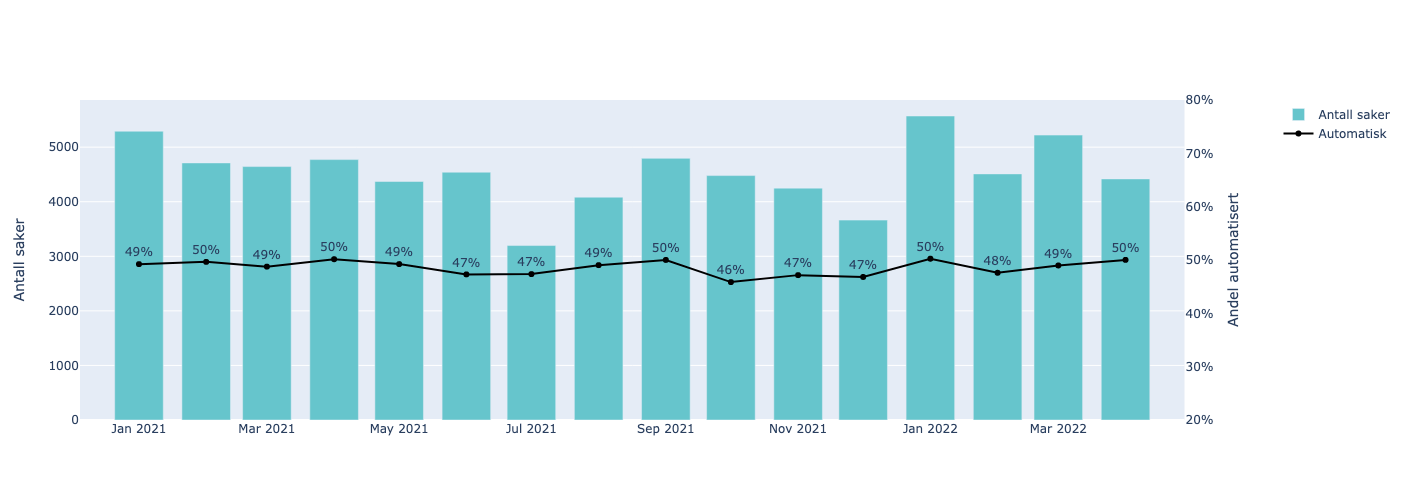

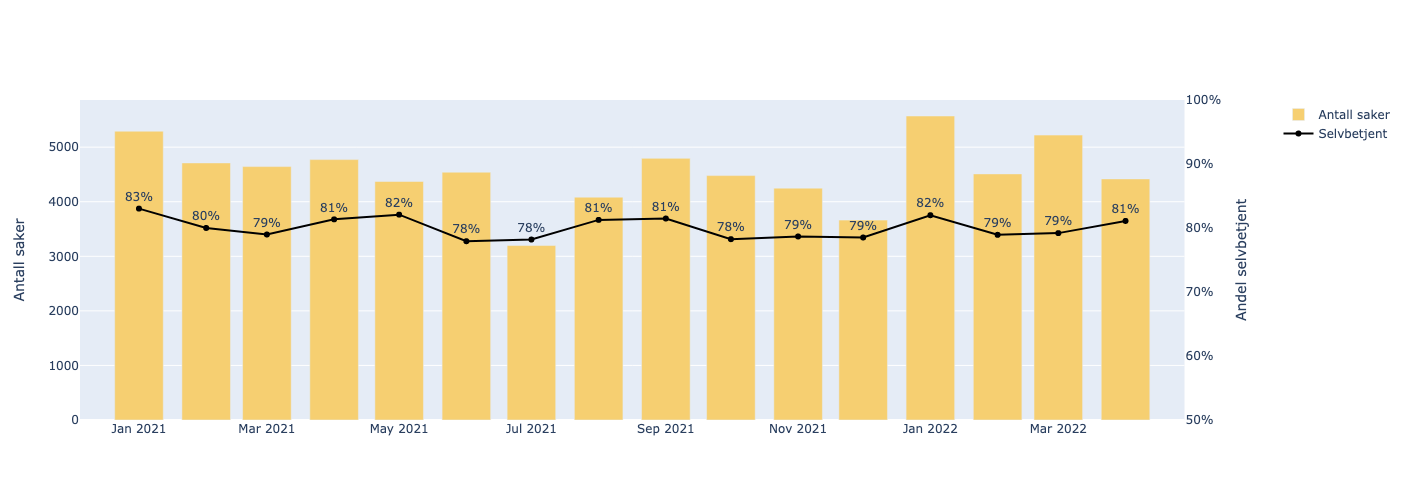

In [276]:
for fig in figs:
    fig.show()

# Publiser datastory

In [277]:
from datastory import DataStory

In [278]:
ds = DataStory(f"Automatiserings- og selvbetjeningsgrad for alderspensjon")

ds.markdown("**(Under utvikling)**")
ds.header(f"Automatisering av førstegangsbehandlingssaker for alderspensjon i pesys. Saker opprettet av batch er eksludert.", level=2)
ds.plotly(figs[0].to_json())

ds.header(f"Selvbetjening av førstegangsbehandlingssaker for alderspensjon i pesys. Saker opprettet av batch er eksludert.", level=2)
ds.plotly(figs[1].to_json())

In [279]:
ds.publish(url="https://nada.intern.nav.no/api") #prod

<IPython.core.display.Javascript object>

'https://data.intern.nav.no/story/draft/bf37ed90-0210-40c5-a3a5-7c051d2a513f'